<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn

In [46]:
from code.dataloader import AgeGroupMLDataset, AgeGroupClfDataset
from code.encoder_gru import Encoder
from code.decoder import Decoder
from code.classifier import Classifier
from code.utils import train_ml_model, train_classifier

In [8]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
SAMPLES_PER_CLASS = 1 # drawing 64x1 classes per batch
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 256
LR = 0.002
NUM_EPOCHS = 150

cat_vocab_sizes = [204]
num_input_dim = 4

In [12]:
dataset = AgeGroupMLDataset()

In [13]:
dataset.load_client_to_indices()

In [14]:
import random

In [15]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [16]:
targets = dataset.targets

In [17]:
sampler = samplers.MPerClassSampler(
    targets, SAMPLES_PER_CLASS, batch_size=BATCH_SIZE,
    length_before_new_iter=BATCH_SIZE * 100) # 100 batches per epoch

In [18]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
    sampler=sampler,
)

In [19]:
encoder = Encoder(
    numerical_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    embedding_dim=EMBEDDING_DIM,
)
encoder.to(device);

In [20]:
optimizer = optim.Adam(encoder.parameters(), lr=LR)

In [21]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")

# sota
# loss_func = losses.ArcFaceLoss(
#     num_classes=len(targets), embedding_size=EMBEDDING_DIM,
#     distance=distance).to(torch.device('cuda')) # not sure why we need to move it to cuda

In [22]:
NUM_EPOCHS = 20

In [25]:
train_losses = train_ml_model(
    encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
    mining_func, loss_func, optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.2160608321428299
Epoch 1 Loss = 0.18478398025035858
Epoch 2 Loss = 0.17138446867465973
Epoch 3 Loss = 0.15935702621936798
Epoch 4 Loss = 0.1540469527244568
Epoch 5 Loss = 0.15160919725894928
Epoch 6 Loss = 0.14864015579223633
Epoch 7 Loss = 0.14732249081134796
Epoch 8 Loss = 0.14597009122371674
Epoch 9 Loss = 0.1454819142818451
Epoch 10 Loss = 0.144046351313591
Epoch 11 Loss = 0.14413465559482574
Epoch 12 Loss = 0.1439066082239151
Epoch 13 Loss = 0.14303511381149292
Epoch 14 Loss = 0.14286723732948303
Epoch 15 Loss = 0.14290452003479004
Epoch 16 Loss = 0.14230357110500336
Epoch 17 Loss = 0.14217700064182281
Epoch 18 Loss = 0.14188829064369202
Epoch 19 Loss = 0.1420808732509613


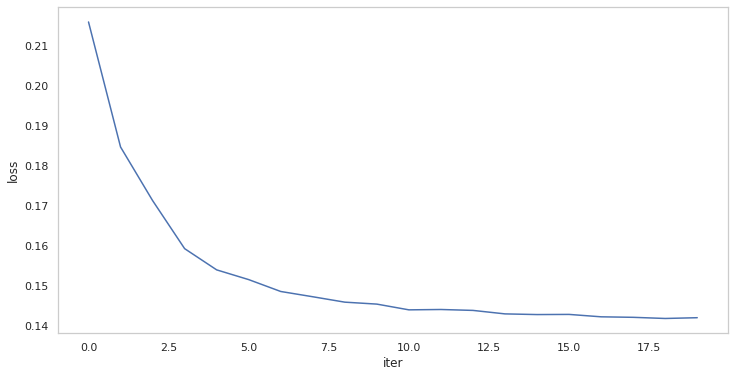

In [26]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.plot(train_losses, label='train')
plt.xlabel('iter')
plt.ylabel('loss');

comparison of encoders
* LSTM
* GRU
* Transformer

comparison for embedding size

# Train classifier

In [29]:
classifier = Classifier(
    numerical_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    embedding_dim=EMBEDDING_DIM
)

In [31]:
classifier.encoder = encoder

In [32]:
classifier.freeze_encoder()

In [34]:
classifier.to(device);

In [35]:
clfdataset = AgeGroupClfDataset()

In [36]:
clfdataset.load_client_to_indices()

In [37]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [38]:
targets = clfdataset.targets

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

In [39]:
clfdataloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

In [40]:
SCHEDULER_EPOCHS = 2

In [41]:
LR = 0.0005

In [42]:
optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=SCHEDULER_EPOCHS,
)

In [43]:
NUM_EPOCHS = 20

In [48]:
train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
    classifier, NUM_EPOCHS, trainloader, testloader,
    optimizer, criterion, scheduler,
    enable_train_mode = lambda: classifier.decoder.train(),
    enable_test_mode = lambda: classifier.decoder.eval(),
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, train acc: 0.5169047713279724, val acc: 0.5325555801391602
train loss: 1.0683094263076782; val loss: 1.0350651741027832
Epoch 1, train acc: 0.5365714430809021, val acc: 0.5336666703224182
train loss: 1.03071129322052; val loss: 1.0177825689315796
Epoch 2, train acc: 0.5400000214576721, val acc: 0.542555570602417
train loss: 1.0281763076782227; val loss: 1.0029356479644775
Epoch 3, train acc: 0.5390952229499817, val acc: 0.5388888716697693
train loss: 1.0203614234924316; val loss: 1.0120792388916016
Epoch 4, train acc: 0.5428095459938049, val acc: 0.5410000085830688
train loss: 1.018089771270752; val loss: 1.0087239742279053
Epoch 5, train acc: 0.5419999957084656, val acc: 0.5383333563804626
train loss: 1.0162798166275024; val loss: 1.009978175163269
Epoch 6, train acc: 0.5427142977714539, val acc: 0.5517777800559998
train loss: 1.0119343996047974; val loss: 0.9952078461647034
Epoch 7, train acc: 0.5489999651908875, val acc: 0.5533333420753479
train loss: 1.0028924942016602; va

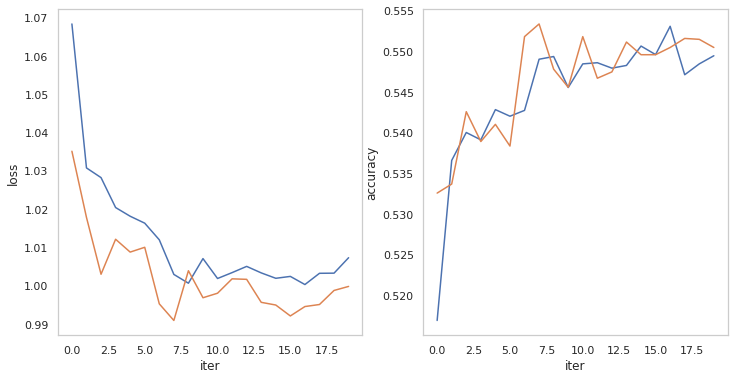

In [49]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('iter')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.xlabel('iter')
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='validation')
plt.ylabel('accuracy');

# Predict (old)

In [ ]:
m = encoder.to('cpu').eval()

In [ ]:
# check
dataiter = iter(dataloader)
sequences, labels = dataiter.next()

# should be BATCH_SIZExNUM_OF_SEQUNCESxSUBSEQUENCE_LENGTHx(num_features)
sequences.shape

In [ ]:
embeddings = torch.zeros((1, EMBEDDING_DIM))[1:]

# probably can make it faster if use a batch of clients
for client_id in tqdm(sorted(dataset.targets)):
    n, c = dataset.get_sequence(client_id)

    with torch.no_grad():
        embedding = m(n, c)
        # encoded_events = m.event_encoder(n, c)
        # encoded_events = encoded_events.view(1, -1, EMBEDDING_DIM)
        # encoded_events = torch.transpose(encoded_events, 0, 1) # so that its (seq_len, batch, input_size)
        # embedding = m.sequence_encoder(encoded_events)[0][0]
        embeddings = torch.cat((embeddings, embedding))

embeddings.shape

In [ ]:
X = embeddings.numpy()

# y = dataset.target_df[dataset.target_df['client_id'].isin(dataset.clients)].sort_values('client_id')['bins'].to_numpy()

y = dataset.target_df.sort_values('client_id')['bins'].to_numpy()

In [ ]:
decoder = Decoder(input_dim=EMBEDDING_DIM)
decoder.to(device);

In [ ]:
from catboost import CatBoostClassifier, Pool
from catboost import cv
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=228, stratify=y)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    depth=3,
    learning_rate=0.5,
    verbose=True,
    eval_metric='Accuracy',
    auto_class_weights='Balanced',
    random_state=228,
)

In [ ]:
model.fit(train_pool, eval_set=test_pool)

In [ ]:
train_acc = model.evals_result_['learn']['Accuracy']
valid_acc = model.evals_result_['validation']['Accuracy']

plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
sum(np.squeeze(model.predict(X_test)) == y_test) / len(y_test)